<a href="https://colab.research.google.com/github/IbrahimMauki/Learning_github/blob/main/PPI_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
!pip install biopython
!pip install ipywidgets --upgrade

!jupyter nbextension enable --py widgetsnbextension
!jupyter nbextension install --py widgetsnbextension

!jupyter labextension install @jupyter-widgets/jupyterlab-manager


Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK
Installing /usr/local/lib/python3.12/dist-packages/widgetsnbextension/static -> jupyter-js-widgets
Up to date: /usr/local/share/jupyter/nbextensions/jupyter-js-widgets/extension.js.map
Up to date: /usr/local/share/jupyter/nbextensions/jupyter-js-widgets/extension.js.LICENSE.txt
Up to date: /usr/local/share/jupyter/nbextensions/jupyter-js-widgets/extension.js
- Validating: OK

    To initialize this nbextension in the browser every time the notebook (or other app) loads:
    
          jupyter nbextension enable widgetsnbextension --py
    
usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exi

## 🧬 GenBank Downloader Script

This script allows users to download GenBank records from NCBI using a valid nucleotide accession number (e.g., `NC_003198.1`, `CP000034.1`). It is designed for reproducibility and ease of use in shared environments like Google Colab.

### 🔹 Features
- Prompts user for email (required by NCBI Entrez) and validates format.
- Accepts standard nucleotide accession formats.
- Saves the GenBank record as a `.gbk` file with a user-defined filename.

### 🔹 Notes
- Only works with **nucleotide accessions** (e.g., NC_, CP_, AY_). Does **not** support GCF_ or GCA_ assembly IDs.
- Uses `gbwithparts` format to include full annotations and features.
- Designed for single-record downloads; batch support can be added later.

### 🔹 Example Usage
```text
Enter your email: user@example.com
Enter accession: NC_003198.1
Output filename: salmonella
```
This will save the GenBank record as salmonella.gbk


In [34]:

from Bio import Entrez
import re

def download_genbank():
    Entrez.email = input("Enter your email: ").strip()
    acc = input("Enter accession (e.g., NC_003198.1 or CP000034.1): ").strip()
    filename = input("Output filename (no extension): ").strip() + ".gbk"

    # ✅ Updated regex: allows NC_003198.1 and CP000034.1
    if not re.match(r"^[A-Z]{2,4}[0-9_]+\.[0-9]+$", acc):
        print("❌ Invalid accession format."); return
    if not re.match(r"[^@]+@[^@]+\.[^@]+", Entrez.email):
        print("❌ Invalid email."); return

    print("⏳ Downloading...")
    try:
        with Entrez.efetch(db="nucleotide", id=acc, rettype="gbwithparts", retmode="text") as handle:
            content = handle.read()

        if "Error:" in content or "failed" in content.lower():
            print("❌ NCBI returned an error. Accession may be invalid or unsupported.")
            return

        with open(filename, "w") as f:
            f.write(content)

        print(f"✔ Saved as: {filename}")

    except Exception as e:
        print(f"❌ Download failed: {e}")

download_genbank()

Enter your email: maukyibrahim@gmail.com
Enter accession (e.g., NC_003198.1 or CP000034.1): NC_003198.1
Output filename (no extension): salmonella
⏳ Downloading...
✔ Saved as: salmonella.gbk


## 🧬 Extract and Annotate Protein-Coding Genes (CDS)

This step parses the GenBank file generated earlier to extract annotated protein-coding genes (CDS features). Each CDS is annotated with:

- **Gene name**
- **Product description**
- **Locus tag**
- **Protein ID**
- **DNA sequence**
- **Translated protein sequence**

### 🔹 Input
- GenBank file (`.gbk`) from previous step, e.g. `salmonella.gbk`

### 🔹 Output
- A pandas DataFrame containing annotated CDS entries
- Ready for export, filtering, or downstream analysis (e.g. BLAST, functional annotation)

### 🔹 Notes
- Missing annotations are filled with `"NA"` to preserve structure
- Translation field may be absent for pseudogenes or incomplete entries

In [24]:
from Bio import SeqIO
import pandas as pd
import os

# === Prompt for GenBank file ===
gbk_file = input("Enter GenBank filename (e.g., salmonella.gbk): ").strip()

# === Check if file exists ===
if not os.path.isfile(gbk_file):
    print(f"❌ ERROR: File '{gbk_file}' not found. Please check the filename and try again.")
else:
    cds_data = []

    for record in SeqIO.parse(gbk_file, "genbank"):
        for feature in record.features:
            if feature.type == "CDS":
                q = feature.qualifiers
                cds_data.append({
                    "Gene": q.get("gene", ["NA"])[0],
                    "Product": q.get("product", ["NA"])[0],
                    "Locus Tag": q.get("locus_tag", ["NA"])[0],
                    "Protein ID": q.get("protein_id", ["NA"])[0],
                    "DNA Sequence": str(feature.location.extract(record).seq),
                    "Protein Sequence": q.get("translation", ["NA"])[0]
                })

    # === Convert to DataFrame ===
    cds_df = pd.DataFrame(cds_data)
    print("✔ CDS features extracted:")
    print(cds_df.head())

Enter GenBank filename (e.g., salmonella.gbk): salmonella.gbk
✔ CDS features extracted:
   Gene                                            Product    Locus Tag  \
0  thrL                          thr operon leader peptide  STY_RS00005   
1  thrA  bifunctional aspartate kinase/homoserine dehyd...  STY_RS00010   
2  thrB                                  homoserine kinase  STY_RS00015   
3  thrC                                 threonine synthase  STY_RS00020   
4  yaaA                       peroxide stress protein YaaA  STY_RS00025   

       Protein ID                                       DNA Sequence  \
0  WP_001575544.1  ATGAACCGCATCAGCACCACCACCATTACCACCATCACCATTACCA...   
1  WP_001264731.1  ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...   
2  WP_000241685.1  ATGGTGAAAGTGTATGCCCCGGCTTCCAGCGCGAACATGAGCGTCG...   
3  WP_000781103.1  ATGAAACTCTATAATCTGAAAGACCATAATGAGCAGGTCAGCTTTG...   
4  WP_000906171.1  ATGCTGATTCTGATTTCACCTGCAAAAACGCTTGATTATCAAAGCC...   

                            

## 🧬 Convert Extracted CDS Data to a Pandas DataFrame

This step transforms the list of extracted CDS annotations into a structured pandas DataFrame for easy preview, filtering, and downstream analysis.

### 🔹 Input
- `cds_data`: A list of dictionaries containing gene name, product, locus tag, protein ID, DNA sequence, and protein sequence.

### 🔹 Output
- `cds_df`: A pandas DataFrame with one row per CDS feature.
- Displays the first few rows using `.head()` to verify successful parsing and structure.

### 🔹 Notes
- This DataFrame can be exported to CSV or integrated into SQLite for further querying.
- Missing annotations are represented as `"NA"` to maintain column consistency.

In [25]:
import pandas as pd

# === Convert extracted CDS data to DataFrame ===
cds_df = pd.DataFrame(cds_data)

# === Preview the first few entries ===
print("✔ Preview of extracted CDS annotations:")
cds_df.head()

✔ Preview of extracted CDS annotations:


,Gene,Product,Locus Tag,Protein ID,DNA Sequence,Protein Sequence
0,thrL,thr operon leader peptide,STY_RS00005,WP_001575544.1,ATGAACCGCATCAGCACCACCACCATTACCACCATCACCATTACCA...,MNRISTTTITTITITTGNGAG
1,thrA,bifunctional aspartate kinase/homoserine dehyd...,STY_RS00010,WP_001264731.1,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,MRVLKFGGTSVANAERFLRVADILESNSRQGQVATVLSAPAKITNH...
2,thrB,homoserine kinase,STY_RS00015,WP_000241685.1,ATGGTGAAAGTGTATGCCCCGGCTTCCAGCGCGAACATGAGCGTCG...,MVKVYAPASSANMSVGFDVLGAAVTPVDGTLLGDVVSVEAADHFRL...
3,thrC,threonine synthase,STY_RS00020,WP_000781103.1,ATGAAACTCTATAATCTGAAAGACCATAATGAGCAGGTCAGCTTTG...,MKLYNLKDHNEQVSFAQAVTQGLGKQQGLFFPHDLPEFSLTEIDEM...
4,yaaA,peroxide stress protein YaaA,STY_RS00025,WP_000906171.1,ATGCTGATTCTGATTTCACCTGCAAAAACGCTTGATTATCAAAGCC...,MLILISPAKTLDYQSPLATTRYTQPELLDHSQQLIQQARQLSAPQI...


## 🧬 Create SQLite Database and Insert Gene Data

This step stores annotated CDS features in a local SQLite database for structured querying and downstream integration.

### 🔹 Input
- `cds_df`: DataFrame containing extracted and annotated CDS features.

### 🔹 Process
1. Connect to (or create) a SQLite database named `pathogen_sequences.db`.
2. Create a table `gene_protein_data` with fields for gene name, product, locus tag, protein ID, DNA sequence, and protein sequence.
3. Clear old records to avoid duplication.
4. Filter out entries with missing or `"NA"` protein IDs.
5. Insert valid records into the database.
6. Preview the number of inserted records and sample entries.

### 🔹 Output
- A populated SQLite table ready for querying, enrichment, or export.

### 🔹 Notes
- This step ensures reproducibility and modularity by storing gene annotations in a structured format.
- Can be extended to support multiple species or strains by adding a `species` or `source_file` column.

In [26]:
import sqlite3

# === Connect to SQLite database ===
db_name = "pathogen_sequences.db"
conn = sqlite3.connect(db_name)
cursor = conn.cursor()

# === Create table for gene annotations ===
cursor.execute("""
CREATE TABLE IF NOT EXISTS gene_protein_data (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    gene_name TEXT,
    product TEXT,
    locus_tag TEXT,
    protein_id TEXT,
    dna_sequence TEXT,
    protein_sequence TEXT
)
""")
conn.commit()

# === Clear old records ===
cursor.execute("DELETE FROM gene_protein_data")
conn.commit()

# === Filter valid entries before insertion ===
filtered_df = cds_df[
    cds_df["Protein ID"].notna() &
    (cds_df["Protein ID"].str.upper() != "NA")
]

# === Insert into database ===
for _, row in filtered_df.iterrows():
    cursor.execute("""
    INSERT INTO gene_protein_data (
        gene_name, product, locus_tag, protein_id, dna_sequence, protein_sequence
    ) VALUES (?, ?, ?, ?, ?, ?)
    """, (
        row["Gene"],
        row["Product"],
        row["Locus Tag"],
        row["Protein ID"],
        row["DNA Sequence"],
        row["Protein Sequence"]
    ))
conn.commit()

# === Verify and preview ===
cursor.execute("SELECT COUNT(*) FROM gene_protein_data")
print("✔ Total records inserted:", cursor.fetchone()[0])

cursor.execute("SELECT protein_id, product FROM gene_protein_data LIMIT 25")
for row in cursor.fetchall():
    print(row)

✔ Total records inserted: 4330
('WP_001575544.1', 'thr operon leader peptide')
('WP_001264731.1', 'bifunctional aspartate kinase/homoserine dehydrogenase I')
('WP_000241685.1', 'homoserine kinase')
('WP_000781103.1', 'threonine synthase')
('WP_000906171.1', 'peroxide stress protein YaaA')
('WP_001113816.1', 'alanine/glycine:cation symporter family protein')
('WP_000130175.1', 'transaldolase')
('WP_001094677.1', 'molybdopterin adenylyltransferase')
('WP_000528527.1', 'acetate uptake transporter')
('WP_001103477.1', 'acidic protein MsyB')
('WP_001258093.1', 'DUF2541 family protein')
('WP_000516126.1', 'molecular chaperone DnaK')
('WP_001119009.1', 'molecular chaperone DnaJ')
('WP_000534904.1', 'LysR family transcriptional regulator')
('WP_000026890.1', 'phage holin family protein')
('WP_001068133.1', 'glycoside hydrolase family 108 protein')
('WP_000860681.1', 'winged helix-turn-helix domain-containing protein')
('WP_000235792.1', 'glycosyl hydrolase family 18 protein')
('WP_000738610.1'

## 🔗 Preparing Data for Interolog-Based PPI Prediction Using STRING

This step formats pathogen protein sequences into FASTA files for submission to the STRING database, enabling interolog-based prediction of host–pathogen protein–protein interactions.

### 🔹 Input
- `gene_protein_data` table in `pathogen_sequences.db`, containing protein IDs and sequences.

### 🔹 Process
1. Connect to the SQLite database and retrieve all non-empty protein sequences.
2. Split sequences into batches of ≤1500 entries (STRING limit is 2000 per submission).
3. Write each batch to a separate FASTA file (`string_fasta_batch_1.fasta`, `string_fasta_batch_2.fasta`, etc.).

### 🔹 Output
- One or more FASTA files ready for upload to the STRING multiple protein input tool.

### 🔹 Notes
- Batching ensures compatibility with STRING’s sequence upload limits.
- These files can be submitted manually or via API (if available) for interaction prediction with *Homo sapiens* (TaxID: 9606).


In [27]:
import sqlite3
import os

# === Connect to SQLite database ===
conn = sqlite3.connect("pathogen_sequences.db")
cursor = conn.cursor()

# === Fetch protein sequences (excluding 'NA') ===
cursor.execute("""
    SELECT protein_id, protein_sequence
    FROM gene_protein_data
    WHERE protein_sequence IS NOT NULL AND protein_sequence != 'NA'
""")
records = cursor.fetchall()

# === Split into batches (STRING limit: ≤2000 sequences per run) ===
def chunk_list(lst, size):
    for i in range(0, len(lst), size):
        yield lst[i:i + size]

batches = list(chunk_list(records, 1500))  # Safe margin under STRING's 2000 limit

# === Save each batch to a FASTA file ===
for i, batch in enumerate(batches, start=1):
    filename = f"string_fasta_batch_{i}.fasta"
    with open(filename, "w") as f:
        for pid, seq in batch:
            f.write(f">{pid}\n{seq}\n")

print(f"✔ Prepared {len(batches)} FASTA batch file(s) for STRING submission.")

✔ Prepared 3 FASTA batch file(s) for STRING submission.


## 🔗 Determining Host–Pathogen Interactions via STRING

This step uses the STRING database to predict interolog-based protein–protein interactions between pathogen proteins and *Homo sapiens*.

### 🔹 Procedure

1. **Prepare FASTA batches**  
   Use the previously generated FASTA files containing ≤1500 pathogen protein sequences each.

2. **Upload to STRING**  
   Go to the [STRING Multiple Proteins by Sequence tool](https://string-db.org/cgi/input?sessionId=bOX9KB4hbW66&input_page_active_form=multiple_sequences) and upload one batch at a time.  
   - Select **Homo sapiens** as the target organism.  
   - Click **Search** to initiate interaction prediction.

3. **Access Mapping Results**  
   After the search completes, click the **Mapping** tab at the top of the results page.

4. **Download Mapping File**  
   STRING will generate a file named `string_mapping.tsv` containing mapped protein identifiers and interaction metadata.

5. **Upload to Colab**  
   Transfer all downloaded mapping files to your Colab environment for downstream filtering, merging, and analysis.

### 🔹 Notes
- Repeat the process for each FASTA batch to cover all pathogen proteins.
- Ensure consistent naming and organization of mapping files for reproducibility.
- These mappings form the basis for filtering high-confidence interologs and integrating with structural data.

## 🔗 Merge STRING Mapping Files and Construct Interaction Database

This step integrates STRING mapping results with local gene annotations to build a high-confidence interaction dataset for downstream analysis.
---
### 🧬 Step 1: Interactive Merging of STRING Mapping Files

This step allows users to select uploaded `.tsv` files interactively using a dropdown with tab-autocomplete and merge them into a single filtered file.

### 🔹 Features
- Lists all `.tsv` files in the current directory.
- Allows multi-file selection via `ipywidgets.SelectMultiple`.
- Filters merged data for identity ≥ 50%.
- Saves output to `merged_string_mapping_identity50.tsv`.

### 🔹 Usage
1. Select files using the dropdown (tab-autocomplete supported).
2. Press **Enter** or click **Merge Selected Files**.
3. View merged preview and summary.

### 🔹 Output
- `merged_string_mapping_identity50.tsv`
- Preview of top 10 rows with identity ≥ 50%

---

### 🧬 Step 2: Link to Local Gene Annotations

1. **Input**:
   - Filtered STRING mapping DataFrame (`combined_df`)
   - Local SQLite database `pathogen_sequences.db` with `gene_protein_data` table
2. **Process**:
   - Extract unique protein IDs from the `queryItem` column.
   - Query the database for matching protein IDs and retrieve associated product annotations.
   - Merge the annotation data with the STRING mapping results.
3. **Output**:
   - `mergedInter_df`: A comprehensive DataFrame linking STRING interaction data with local gene product annotations.

---

### 🔹 Notes
- This step enables biological interpretation of STRING-derived interactions by linking them to annotated gene products.
- The merged dataset can be used for downstream filtering, visualization, or network construction.

In [28]:
import pandas as pd
import os
import ipywidgets as widgets
from IPython.display import display

# === Step 1: List available TSV files ===
available_files = [f for f in os.listdir() if f.endswith(".tsv")]

# === Step 2: Interactive file selector ===
file_selector = widgets.SelectMultiple(
    options=available_files,
    description="TSV Files",
    layout=widgets.Layout(width='100%'),
    style={'description_width': 'initial'}
)

display(file_selector)

# === Step 3: Button to trigger merge ===
merge_button = widgets.Button(description="Merge Selected Files", button_style='success')
output = widgets.Output()

def merge_files(b):
    selected_files = list(file_selector.value)
    if not selected_files:
        with output:
            output.clear_output()
            print("⚠️ No files selected.")
        return

    dfs = []
    for f in selected_files:
        print(f"Reading {f} ...")
        df = pd.read_csv(f, sep="\t")
        dfs.append(df)

    combined_df = pd.concat(dfs, ignore_index=True)
    combined_df = combined_df[combined_df["identity"] >= 50]

    output_file = "merged_string_mapping_identity50.tsv"
    combined_df.to_csv(output_file, sep="\t", index=False)

    with output:
        output.clear_output()
        print(f"\n✅ Merged and filtered {len(selected_files)} files into '{output_file}'")
        print(f"Total rows with identity ≥ 50: {len(combined_df)}\n")
        display(combined_df.head(10))

merge_button.on_click(merge_files)
display(merge_button, output)

SelectMultiple(description='TSV Files', layout=Layout(width='100%'), options=('string_mapping (6).tsv', 'strin…

Button(button_style='success', description='Merge Selected Files', style=ButtonStyle())

Output()

Reading string_mapping (6).tsv ...
Reading string_mapping (5).tsv ...
Reading string_mapping (4).tsv ...


In [29]:
# === Step 2: Link STRING hits to local gene annotations ===

# Connect to SQLite database
conn = sqlite3.connect("pathogen_sequences.db")
cursor = conn.cursor()

# Extract unique protein IDs from STRING mapping
protein_ids = combined_df["queryItem"].dropna().unique().tolist()

# Prepare SQL placeholders
placeholders = ",".join(["?"] * len(protein_ids))

# Query local gene annotations for matching protein IDs
query = f"""
SELECT protein_ID, product
FROM gene_protein_data
WHERE protein_ID IN ({placeholders})
"""
cursor.execute(query, protein_ids)
rows = cursor.fetchall()

# Convert to DataFrame
product_df = pd.DataFrame(rows, columns=["protein_ID", "product"])
product_df = product_df.drop_duplicates(subset="protein_ID", keep="first")

# Merge with STRING mapping results
mergedInter_df = combined_df.merge(
    product_df,
    how="left",
    left_on="queryItem",
    right_on="protein_ID"
)

# Display summary
print(f"Records matched after deduplication: {len(product_df)}")
print(f"Total rows in mergedInter_df: {len(mergedInter_df)}\n")
mergedInter_df.head(10)

Records matched after deduplication: 0
Total rows in mergedInter_df: 54



,#queryIndex,queryItem,stringId,identity,bitscore,preferredName,annotation,protein_ID,product
0,7,WP_002887897.1,9606.ENSP00000321259,60.4,372.9,TALDO1,Transaldolase; Transaldolase is important for ...,NaN,NaN
1,13,WP_004146997.1,9606.ENSP00000297185,60.4,720.7,HSPA9,"Stress-70 protein, mitochondrial; Chaperone pr...",NaN,NaN
2,107,WP_004145938.1,9606.ENSP00000259727,66.3,468.0,GMPR,GMP reductase 1; Catalyzes the irreversible NA...,NaN,NaN
3,251,WP_002889845.1,9606.ENSP00000314649,55.0,539.7,ALDH5A1,"Succinate-semialdehyde dehydrogenase, mitochon...",NaN,NaN
4,401,WP_002891804.1,9606.ENSP00000245816,56.2,235.7,CLPP,ATP-dependent Clp protease proteolytic subunit...,NaN,NaN
5,459,WP_002892184.1,9606.ENSP00000499935,53.7,203.8,AK2,"Adenylate kinase 2, mitochondrial, N-terminall...",NaN,NaN
6,597,WP_004147503.1,9606.ENSP00000346827,51.3,491.5,ALDH9A1,"4-trimethylaminobutyraldehyde dehydrogenase, N...",NaN,NaN
7,707,WP_002894749.1,9606.ENSP00000423674,60.9,330.1,GNPDA1,Glucosamine-6-phosphate isomerase 1; Seems to ...,NaN,NaN
8,742,WP_004179067.1,9606.ENSP00000264932,55.3,575.9,SDHA,Succinate dehydrogenase [ubiquinone] flavoprot...,NaN,NaN
9,743,WP_002894954.1,9606.ENSP00000364649,56.4,265.0,SDHB,Succinate dehydrogenase [ubiquinone] iron-sulf...,NaN,NaN


## 🧠 Host–Pathogen PPI Network Construction in Neo4j

This step builds a graph-based protein–protein interaction (PPI) network using Neo4j, enabling flexible querying and visualization of interolog-based predictions.

---

### 🔹 Notes
- Neo4j enables flexible graph queries, ideal for exploring interaction neighborhoods, hubs, and filtering by confidence.
---

### 🔹 Step 1: Install and Start Neo4j
- Installs Neo4j and its dependencies in Colab.
- Sets an initial password and starts the Neo4j service.


In [ ]:
# Install Neo4j and dependencies
!apt-get -y install openjdk-17-jre-headless
!wget -qO - https://debian.neo4j.com/neotechnology.gpg.key | apt-key add -
!echo 'deb https://debian.neo4j.com stable 5' | tee /etc/apt/sources.list.d/neo4j.list
!apt-get update -q
!apt-get -y install neo4j

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
openjdk-17-jre-headless is already the newest version (17.0.16+8~us1-0ubuntu1~22.04.1).
openjdk-17-jre-headless set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.
OK
deb https://debian.neo4j.com stable 5
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cli.github.com/packages stable InRelease [3,917 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:4 https://debian.neo4j.com stable InRelease [44.3 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:8 https://cli.github.com/packages stable/main amd64 Packages [343 B]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:10

In [ ]:
# Set initial password and start Neo4j service
!neo4j-admin dbms set-initial-password mypassword
!neo4j start

Changed password for user 'neo4j'. IMPORTANT: this change will only take effect if performed before the database is started for the first time.
Directories in use:
home:         /var/lib/neo4j
config:       /etc/neo4j
logs:         /var/log/neo4j
plugins:      /var/lib/neo4j/plugins
import:       /var/lib/neo4j/import
data:         /var/lib/neo4j/data
certificates: /var/lib/neo4j/certificates
licenses:     /var/lib/neo4j/licenses
run:          /var/lib/neo4j/run
Starting Neo4j.
Started neo4j (pid:47060). It is available at http://localhost:7474
There may be a short delay until the server is ready.


### 🔹 Step 2: Connect to Neo4j

In [ ]:
!pip install neo4j pandas tqdm
from neo4j import GraphDatabase

uri = "bolt://localhost:7687"
user = "neo4j"
password = "mypassword"

driver = GraphDatabase.driver(uri, auth=(user, password))
print("✅ Connected to local Neo4j instance")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.4/325.4 kB 4.6 MB/s eta 0:00:00
✅ Connected to local Neo4j instance


### 🔹 Step 3: Create Schema
- Defines a uniqueness constraint on `protein_id` to prevent duplicate nodes.

In [ ]:
def create_schema(tx):
    tx.run("""
    CREATE CONSTRAINT protein_id_unique IF NOT EXISTS
    FOR (p:Protein)
    REQUIRE p.protein_id IS UNIQUE
    """)

with driver.session() as session:
    session.execute_write(create_schema)

print("✅ Schema ready")

✅ Schema ready


### 🔹 Step 4: Insert PPI Data into Neo4j
- Iterates through the merged STRING–annotation dataset.
- Creates `Protein` nodes and `INTERACTS_WITH` relationships with identity and bitscore attributes.

In [ ]:
from tqdm import tqdm

def insert_ppi(tx, row):
    tx.run("""
    MERGE (p1:Protein {protein_id: $queryItem})
      ON CREATE SET p1.product = $product

    MERGE (p2:Protein {protein_id: $stringId})
      ON CREATE SET p2.annotation = $annotation

    MERGE (p1)-[r:INTERACTS_WITH]->(p2)
      ON CREATE SET r.identity = $identity, r.bitscore = $bitscore
    """, {
        "queryItem": row.get("queryItem"),
        "stringId": row.get("stringId"),
        "product": row.get("product"),
        "annotation": row.get("annotation"),
        "identity": float(row.get("identity")) if pd.notna(row.get("identity")) else None,
        "bitscore": float(row.get("bitscore")) if pd.notna(row.get("bitscore")) else None
    })

records = mergedInter_df.to_dict("records")

with driver.session() as session:
    for row in tqdm(records, desc="Uploading PPI network to Neo4j"):
        try:
            session.execute_write(insert_ppi, row)
        except Exception as e:
            print(f"⚠️ Skipped record {row.get('queryItem')} → {row.get('stringId')}: {e}")

print("✅ PPI network uploaded successfully to Neo4j")

Uploading PPI network to Neo4j: 100%|██████████| 42/42 [00:03<00:00, 12.31it/s]

✅ PPI network uploaded successfully to Neo4j


### 🔹 Step 5: Query Example
- Retrieves and displays sample interactions from the graph.


In [ ]:
with driver.session() as session:
    result = session.run("""
        MATCH (p:Protein)-[r:INTERACTS_WITH]->(q:Protein)
        RETURN
            p.protein_id AS Source,
            q.protein_id AS Target,
            r.identity AS Identity,
            r.bitscore AS Bitscore
    """)

    print("🧬 Example PPI Interactions:\n")
    for record in result:
        print(f"{record['Source']} --({record['Identity']}%)--> {record['Target']}  [Bitscore: {record['Bitscore']}]")

🧬 Example PPI Interactions:

WP_000130187.1 --(59.8%)--> 9606.ENSP00000321259  [Bitscore: 372.1]
WP_000516135.1 --(60.2%)--> 9606.ENSP00000297185  [Bitscore: 721.1]
WP_001217371.1 --(66.0%)--> 9606.ENSP00000259727  [Bitscore: 470.3]
WP_000122253.1 --(56.2%)--> 9606.ENSP00000245816  [Bitscore: 235.7]
WP_005019454.1 --(53.7%)--> 9606.ENSP00000499935  [Bitscore: 204.1]
WP_023438539.1 --(53.3%)--> 9606.ENSP00000368793  [Bitscore: 63.2]
WP_001237084.1 --(59.7%)--> 9606.ENSP00000423674  [Bitscore: 325.9]
WP_000775528.1 --(55.3%)--> 9606.ENSP00000264932  [Bitscore: 570.5]
WP_001235253.1 --(55.6%)--> 9606.ENSP00000364649  [Bitscore: 261.2]
WP_000025448.1 --(66.6%)--> 9606.ENSP00000377446  [Bitscore: 377.1]
WP_005019991.1 --(58.5%)--> 9606.ENSP00000359991  [Bitscore: 310.5]
WP_000191540.1 --(56.3%)--> 9606.ENSP00000368119  [Bitscore: 421.8]
WP_001265469.1 --(52.2%)--> 9606.ENSP00000483375  [Bitscore: 374.0]
WP_000153502.1 --(66.1%)--> 9606.ENSP00000380070  [Bitscore: 440.7]
WP_011378711.1 --(50

### 🔹 Step 6: Export Interaction Table
- Converts the full graph query result into a pandas DataFrame for downstream analysis or export.

In [ ]:
with driver.session() as session:
    query = """
    MATCH (p:Protein)-[r:INTERACTS_WITH]->(q:Protein)
    RETURN p.protein_id, p.product, q.protein_id, q.annotation, r.identity, r.bitscore
    """
    df = pd.DataFrame([dict(record) for record in session.run(query)])
df.tail()

,p.protein_id,p.product,q.protein_id,q.annotation,r.identity,r.bitscore
36,WP_000789986.1,glucose-6-phosphate isomerase,9606.ENSP00000405573,Glucose-6-phosphate isomerase; In the cytoplas...,64.8,727.2
37,WP_000095944.1,methionine synthase,9606.ENSP00000355536,Methionine synthase; Catalyzes the transfer of...,53.2,1254.6
38,WP_000188764.1,FKBP-type peptidyl-prolyl cis-trans isomerase,9606.ENSP00000498991,Uncharacterized protein LOC114841035.,54.0,87.8
39,WP_000729117.1,chaperonin GroEL,9606.ENSP00000340019,"60 kDa heat shock protein, mitochondrial; Chap...",50.7,518.5
40,WP_005021358.1,peptide-methionine (S)-S-oxide reductase MsrA,9606.ENSP00000313921,Mitochondrial peptide methionine sulfoxide red...,59.6,255.8


## 🧠 Visualization and Network Analysis of Host–Pathogen PPIs

This step visualizes and analyzes the protein–protein interaction (PPI) network derived from STRING and annotated with local gene data.

---

### 🔹 Visualization

1. **NetworkX Plot**  
   - Builds a directed graph using `networkx` and `matplotlib`.
   - Nodes are colored by type: query proteins (skyblue) and partner proteins (lightcoral).
   - Edge attributes include identity and bitscore.

2. **Interactive PyVis Network**  
   - Uses `pyvis` to create an interactive HTML-based network.
   - Edge color reflects sequence identity (red to green gradient).
   - Edge thickness reflects bitscore strength.

---

### 🔹 Graph Construction and Analysis

1. **Extract Data from Neo4j**  
   - Retrieves all `INTERACTS_WITH` relationships and associated attributes.

2. **Build NetworkX Graph**  
   - Constructs an undirected graph with edge attributes.

3. **Compute Network Properties**  
   - Nodes, edges, density, and connected components.

4. **Node-Level Metrics**  
   - Degree, clustering coefficient, betweenness, and closeness centrality.

5. **Identify Hub Proteins**  
   - Lists top 20 proteins with highest degree (most interactions).

---

### 🔹 Notes

- These metrics help identify key proteins potentially involved in host–pathogen interactions.
- Hub proteins may serve as candidates for functional validation or therapeutic targeting.

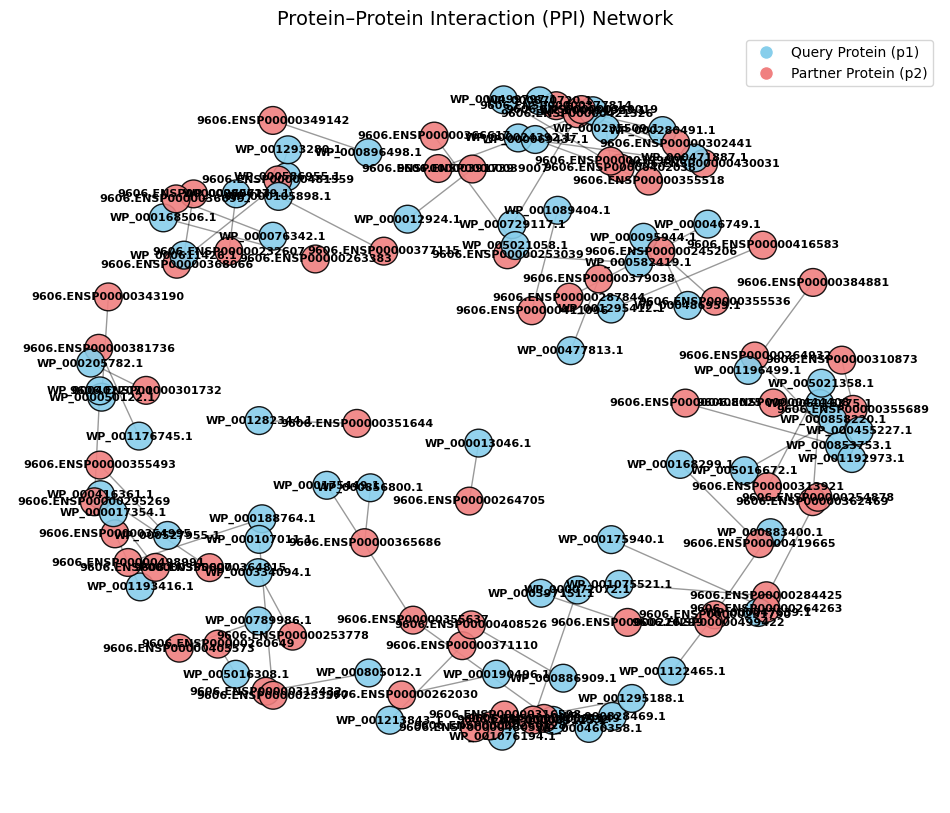


Example Node Descriptions:
WP_000499797.1: MTO1
9606.ENSP00000402038: Protein MTO1 homolog, mitochondrial; Involved in the 5-carboxymethylaminomethyl modification (mnm(5)s(2)U34) of the wobble uridine base in mitochondrial tRNAs. Belongs to the MnmG family.
WP_001176745.1: ATP5F1A
9606.ENSP00000381736: ATP synthase subunit alpha, mitochondrial; Mitochondrial membrane ATP synthase (F(1)F(0) ATP synthase or Complex V) produces ATP from ADP in the presence of a proton gradient across the membrane which is generated by electron transport complexes of the respiratory chain. F-type ATPases consist of two structural domains, F(1) - containing the extramembraneous catalytic core, and F(0) - containing the membrane proton channel, linked together by a central stalk and a peripheral stalk. During catalysis, ATP synthesis in the catalytic domain of F(1) is coupled via a rotary mechanism of the  [...] 
WP_000896498.1: ATP5F1C


In [ ]:
# Step 1: Visualize PPI Network with NetworkX
import networkx as nx
import matplotlib.pyplot as plt

# Create undirected graph from DataFrame
G = nx.from_pandas_edgelist(
    df,
    source='queryItem',
    target='stringId',
    edge_attr=['identity', 'bitscore'],
    create_using=nx.Graph()
)

# Add node attributes
for _, row in df.iterrows():
    # Query protein (pathogen)
    G.nodes[row['queryItem']]['description'] = row.get('preferredName', 'N/A')
    G.nodes[row['queryItem']]['type'] = 'p1'

    # Partner protein (STRING)
    G.nodes[row['stringId']]['description'] = row.get('annotation', 'N/A')
    G.nodes[row['stringId']]['type'] = 'p2'

# Assign node colors
node_colors = [
    'skyblue' if G.nodes[n].get('type') == 'p1' else 'lightcoral'
    for n in G.nodes
]

# Layout and draw
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.4, seed=42)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=400, alpha=0.9, edgecolors='k')
nx.draw_networkx_edges(G, pos, alpha=0.4)
nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

# Legend
p1_patch = plt.Line2D([0], [0], marker='o', color='w', label='Query Protein (p1)', markerfacecolor='skyblue', markersize=10)
p2_patch = plt.Line2D([0], [0], marker='o', color='w', label='Partner Protein (p2)', markerfacecolor='lightcoral', markersize=10)
plt.legend(handles=[p1_patch, p2_patch], loc='best')

plt.title("Protein–Protein Interaction (PPI) Network", fontsize=14)
plt.axis('off')
plt.show()

# Inspect node descriptions
print("\nExample Node Descriptions:")
for node, data in list(G.nodes(data=True))[:5]:
    print(f"{node}: {data.get('description')}")


In [ ]:
# Step 2: Interactive Visualization with PyVis
!pip install pyvis

import pandas as pd
from pyvis.network import Network
from IPython.display import IFrame, display, HTML

# Initialize PyVis network
ppi_net = Network(
    height="750px",
    width="100%",
    bgcolor="#ffffff",
    directed=False,   # undirected network
    notebook=True,
    cdn_resources='in_line'
)

# Normalize bitscores for visualization (edge thickness)
max_bitscore = df["bitscore"].max() if "bitscore" in df.columns else 1

# Function to map identity to a color gradient (low = red, high = green)
def identity_to_color(identity):
    try:
        val = float(identity)
    except:
        return "gray"
    r = int(255 * (1 - val / 100))
    g = int(255 * (val / 100))
    return f"rgb({r},{g},0)"

# Add nodes and edges
for _, row in df.iterrows():
    p1 = row["queryItem"]       # pathogen/query protein
    p2 = row["stringId"]        # STRING partner protein
    identity = row.get("identity", 0)
    bitscore = row.get("bitscore", 1)
    product = row.get("preferredName", "N/A")
    annotation = row.get("annotation", "N/A")

    # Add node for query protein
    ppi_net.add_node(
        p1,
        label=p1,
        title=f"<b>Protein:</b> {p1}<br><b>Product:</b> {product}",
        color="skyblue"
    )

    # Add node for partner protein
    ppi_net.add_node(
        p2,
        label=p2,
        title=f"<b>Protein:</b> {p2}<br><b>Annotation:</b> {annotation}",
        color="lightcoral"
    )

    # Edge color by identity, thickness by bitscore
    edge_color = identity_to_color(identity)
    edge_width = (bitscore / max_bitscore) * 10

    ppi_net.add_edge(
        p1,
        p2,
        title=f"<b>Identity:</b> {identity}%<br><b>Bitscore:</b> {bitscore}",
        color=edge_color,
        width=edge_width,
        value=float(bitscore)
    )

# Optional: improve layout physics for complex networks
ppi_net.set_options("""
var options = {
  "physics": {
    "barnesHut": {
      "gravitationalConstant": -30000,
      "springLength": 200
    },
    "minVelocity": 0.75
  }
}
""")

# Save and display

# Save the network to HTML
ppi_net.save_graph("ppi_network.html")


# ✅ Render directly with HTML
with open("ppi_network.html", "r") as f:
    html_content = f.read()
display(HTML(html_content))

In [ ]:
# Step 3: Extract Data from Neo4j
from neo4j import GraphDatabase
import pandas as pd

# --- Neo4j Connection ---
uri = "bolt://localhost:7687"
user = "neo4j"
password = "mypassword"

driver = GraphDatabase.driver(uri, auth=(user, password))

# --- Query all interactions ---
with driver.session() as session:
    result = session.run("""
        MATCH (p:Protein)-[r:INTERACTS_WITH]->(q:Protein)
        RETURN
            p.protein_id AS queryItem,
            q.protein_id AS stringId,
            r.identity AS identity,
            r.bitscore AS bitscore,
            p.product AS preferredName,
            q.annotation AS annotation
    """)
    df = pd.DataFrame([record.data() for record in result])

driver.close()

print("✅ Retrieved", len(df), "interactions from Neo4j")
print(df.head())


✅ Retrieved 41 interactions from Neo4j
        queryItem              stringId  identity  bitscore  \
0  WP_000130187.1  9606.ENSP00000321259      59.8     372.1   
1  WP_000516135.1  9606.ENSP00000297185      60.2     721.1   
2  WP_001217371.1  9606.ENSP00000259727      66.0     470.3   
3  WP_000122253.1  9606.ENSP00000245816      56.2     235.7   
4  WP_005019454.1  9606.ENSP00000499935      53.7     204.1   

                                       preferredName  \
0                                      transaldolase   
1                           molecular chaperone DnaK   
2                                      GMP reductase   
3  ATP-dependent Clp endopeptidase proteolytic su...   
4                                   adenylate kinase   

                                          annotation  
0  Transaldolase; Transaldolase is important for ...  
1  Stress-70 protein, mitochondrial; Chaperone pr...  
2  GMP reductase 1; Catalyzes the irreversible NA...  
3  ATP-dependent Clp prot

In [ ]:
# Step 4: Build NetworkX Graph
import networkx as nx

# Build undirected graph using correct column names
G = nx.from_pandas_edgelist(
    df,
    source='queryItem',       # pathogen/query protein
    target='stringId',        # STRING partner protein
    edge_attr=['identity', 'bitscore'],
    create_using=nx.Graph()
)

print(f"✅ Graph built: {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")


✅ Graph built: 81 nodes and 41 edges


In [ ]:
# Step 5: Compute Network-Level Properties
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
density = nx.density(G)
components = nx.number_connected_components(G)

print(f"""
📊 Network Summary:
- Nodes (Proteins): {num_nodes}
- Edges (Interactions): {num_edges}
- Density: {density:.4f}
- Connected Components: {components}
""")



📊 Network Summary:
- Nodes (Proteins): 81
- Edges (Interactions): 41
- Density: 0.0127
- Connected Components: 40



In [ ]:
# Step 6: Node-Level Topological Measures
degree_dict = dict(G.degree())

# Use correct edge attribute names: 'bitscore' not 'Bitscore'
clustering_dict = nx.clustering(G, weight='bitscore')
betweenness_dict = nx.betweenness_centrality(G, weight='bitscore', normalized=True)
closeness_dict = nx.closeness_centrality(G)

# Build metrics DataFrame
metrics_df = pd.DataFrame({
    "Protein": list(G.nodes()),
    "Degree": [degree_dict[n] for n in G.nodes()],
    "Clustering": [clustering_dict[n] for n in G.nodes()],
    "Betweenness": [betweenness_dict[n] for n in G.nodes()],
    "Closeness": [closeness_dict[n] for n in G.nodes()]
}).sort_values("Degree", ascending=False)

display(metrics_df.head(10))


,Protein,Degree,Clustering,Betweenness,Closeness
29,9606.ENSP00000264663,2,0,0.000316,0.0250
1,9606.ENSP00000321259,1,0,0.000000,0.0125
2,WP_000516135.1,1,0,0.000000,0.0125
3,9606.ENSP00000297185,1,0,0.000000,0.0125
4,WP_001217371.1,1,0,0.000000,0.0125
5,9606.ENSP00000259727,1,0,0.000000,0.0125
6,WP_000122253.1,1,0,0.000000,0.0125
7,9606.ENSP00000245816,1,0,0.000000,0.0125
8,WP_005019454.1,1,0,0.000000,0.0125
9,9606.ENSP00000499935,1,0,0.000000,0.0125


In [ ]:
top_hubs = metrics_df.nlargest(20, 'Degree')
print("🧬 Top Hub Proteins (by number of interactions):\n")
display(top_hubs)

🧬 Top Hub Proteins (by number of interactions):



,Protein,Degree,Clustering,Betweenness,Closeness
29,9606.ENSP00000264663,2,0,0.000316,0.0250
1,9606.ENSP00000321259,1,0,0.000000,0.0125
2,WP_000516135.1,1,0,0.000000,0.0125
3,9606.ENSP00000297185,1,0,0.000000,0.0125
4,WP_001217371.1,1,0,0.000000,0.0125
5,9606.ENSP00000259727,1,0,0.000000,0.0125
6,WP_000122253.1,1,0,0.000000,0.0125
7,9606.ENSP00000245816,1,0,0.000000,0.0125
8,WP_005019454.1,1,0,0.000000,0.0125
9,9606.ENSP00000499935,1,0,0.000000,0.0125


## 🧬 End-to-End PPI Network Analysis

This workflow extracts protein–protein interactions from Neo4j, builds a NetworkX graph, computes topological measures, and visualizes the network.

---

### 🔹 Steps

1. **Import libraries**  
   Load `neo4j`, `pandas`, `networkx`, and `matplotlib`.

2. **Extract interactions from Neo4j**  
   - Query all `INTERACTS_WITH` relationships.  
   - Return pathogen proteins (`queryItem`), STRING partners (`stringId`), sequence identity, bitscore, product name, and annotation.  
   - Store results in a Pandas DataFrame.

3. **Build NetworkX graph**  
   - Construct an undirected graph.  
   - Nodes = proteins.  
   - Edges = interactions with attributes (`identity`, `bitscore`).

4. **Compute topological measures**  
   - Degree (hubness).  
   - Betweenness centrality (bridging importance).  
   - Clustering coefficient (modularity).  
   - Store metrics as node attributes.

5. **Network summary statistics**  
   - Nodes, edges, density, connected components.

6. **Prepare visualization**  
   - Use spring layout.  
   - Node size scaled by degree.  
   - Node color mapped to betweenness centrality.

7. **Plot network**  
   - Edges drawn with transparency.  
   - Nodes colored by betweenness, sized by degree.  
   - Labels shown for top 20 hubs.  
   - Colorbar indicates betweenness centrality.

8. **Save metrics**  
   - Export metrics to `PPI_network_metrics.csv`.  
   - Preview top hub proteins.

---

### 🔹 Output
- Interactive visualization of the PPI network.  
- CSV file with node-level metrics for downstream analysis.  
- Identification of hub proteins and bridging nodes.

✅ Retrieved 41 interactions from Neo4j
        queryItem              stringId  identity  bitscore  \
0  WP_000130187.1  9606.ENSP00000321259      59.8     372.1   
1  WP_000516135.1  9606.ENSP00000297185      60.2     721.1   
2  WP_001217371.1  9606.ENSP00000259727      66.0     470.3   
3  WP_000122253.1  9606.ENSP00000245816      56.2     235.7   
4  WP_005019454.1  9606.ENSP00000499935      53.7     204.1   

                                       preferredName  \
0                                      transaldolase   
1                           molecular chaperone DnaK   
2                                      GMP reductase   
3  ATP-dependent Clp endopeptidase proteolytic su...   
4                                   adenylate kinase   

                                          annotation  
0  Transaldolase; Transaldolase is important for ...  
1  Stress-70 protein, mitochondrial; Chaperone pr...  
2  GMP reductase 1; Catalyzes the irreversible NA...  
3  ATP-dependent Clp prot

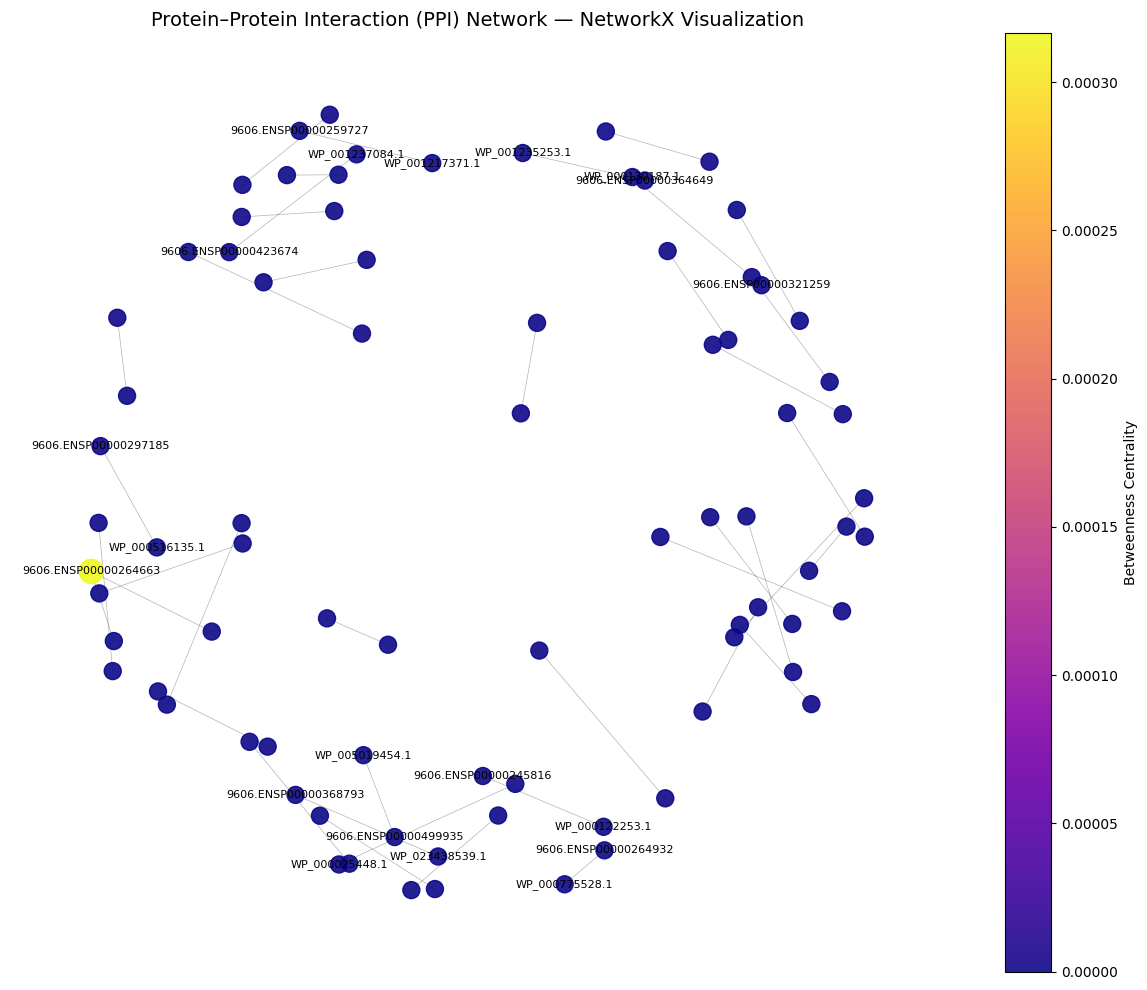

✅ Network metrics saved to 'PPI_network_metrics.csv'
                 Protein  Degree  Betweenness  Clustering
29  9606.ENSP00000264663       2     0.000316           0
1   9606.ENSP00000321259       1     0.000000           0
2         WP_000516135.1       1     0.000000           0
3   9606.ENSP00000297185       1     0.000000           0
4         WP_001217371.1       1     0.000000           0
5   9606.ENSP00000259727       1     0.000000           0
6         WP_000122253.1       1     0.000000           0
7   9606.ENSP00000245816       1     0.000000           0
8         WP_005019454.1       1     0.000000           0
9   9606.ENSP00000499935       1     0.000000           0


In [ ]:
# ============================================================
# 1. Import libraries
# ============================================================
from neo4j import GraphDatabase
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# ============================================================
# 2. Connect to Neo4j and extract interactions
# ============================================================
uri = "bolt://localhost:7687"   # change if remote
user = "neo4j"
password = "mypassword"         # replace with your actual password

driver = GraphDatabase.driver(uri, auth=(user, password))

with driver.session() as session:
    result = session.run("""
        MATCH (p:Protein)-[r:INTERACTS_WITH]->(q:Protein)
        RETURN
            p.protein_id AS queryItem,
            q.protein_id AS stringId,
            r.identity AS identity,
            r.bitscore AS bitscore,
            p.product AS preferredName,
            q.annotation AS annotation
    """)
    df = pd.DataFrame([record.data() for record in result])

driver.close()

print(f"✅ Retrieved {len(df)} interactions from Neo4j")
print(df.head())

# ============================================================
# 3. Build undirected NetworkX graph
# ============================================================
G = nx.from_pandas_edgelist(
    df,
    source='queryItem',
    target='stringId',
    edge_attr=['identity', 'bitscore'],
    create_using=nx.Graph()
)

print(f"✅ Graph built: {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

# ============================================================
# 4. Compute topological measures
# ============================================================
degree = dict(G.degree())
betweenness = nx.betweenness_centrality(G, weight='bitscore', normalized=True)
clustering = nx.clustering(G, weight='bitscore')

# Add metrics as node attributes for later visualization
nx.set_node_attributes(G, degree, 'Degree')
nx.set_node_attributes(G, betweenness, 'Betweenness')
nx.set_node_attributes(G, clustering, 'Clustering')

# ============================================================
# 5. Network summary statistics
# ============================================================
print(f"""
📊 Network Summary:
- Nodes: {G.number_of_nodes()}
- Edges: {G.number_of_edges()}
- Density: {nx.density(G):.4f}
- Connected Components: {nx.number_connected_components(G)}
""")

# ============================================================
# 6. Prepare for visualization
# ============================================================
# Layout options: spring_layout, kamada_kawai_layout, spectral_layout
pos = nx.spring_layout(G, seed=42, k=0.5)

# Node color & size mapping
node_color = [betweenness[n] for n in G.nodes()]
node_size = [degree[n] * 150 for n in G.nodes()]  # scale node size by degree

# ============================================================
# 7. Plot network with NetworkX
# ============================================================
plt.figure(figsize=(12, 10))
nx.draw_networkx_edges(G, pos, alpha=0.3, width=0.5)

# Draw nodes — colored by betweenness, sized by degree
nodes = nx.draw_networkx_nodes(
    G,
    pos,
    node_size=node_size,
    node_color=node_color,
    cmap=plt.cm.plasma,
    alpha=0.9
)

# Draw labels only for top hubs
top_hubs = sorted(degree.items(), key=lambda x: x[1], reverse=True)[:20]
nx.draw_networkx_labels(
    G,
    pos,
    labels={n: n for n, _ in top_hubs}, # comment if you want to label all nodes
    font_size=8,
    font_color='black'
)

plt.colorbar(nodes, label="Betweenness Centrality")
plt.title("Protein–Protein Interaction (PPI) Network — NetworkX Visualization", fontsize=14)
plt.axis("off")
plt.tight_layout()
plt.show()

# ============================================================
# 8. Save network metrics
# ============================================================
metrics_df = pd.DataFrame({
    "Protein": list(G.nodes()),
    "Degree": [degree[n] for n in G.nodes()],
    "Betweenness": [betweenness[n] for n in G.nodes()],
    "Clustering": [clustering[n] for n in G.nodes()]
})
metrics_df = metrics_df.sort_values("Degree", ascending=False)
metrics_df.to_csv("PPI_network_metrics.csv", index=False)

print("✅ Network metrics saved to 'PPI_network_metrics.csv'")
print(metrics_df.head(10))


> **Note:**  
> To validate predicted host–pathogen interactions, please cross-check with the **PHISTO database**.  
> - Go to the PHISTO portal.  
> - Search for the **queried organism** (e.g., *Salmonella enterica*, *Homo sapiens*).  
> - Review the currently available **experimentally validated interactions**.  
> This step ensures that your computational predictions are supported by known biological evidence.


## 🧬 Functional and Pathway Enrichment Preparation

This step prepares host gene lists for downstream enrichment analysis (GO terms, KEGG pathways, Reactome, etc.).

---

### 🔹 Step 1: Extract Host Gene Symbols
- Load merged STRING mapping file.
- Extract unique host gene names (`preferredName`).
- Save gene list to `host_genes_for_enrichment.txt`.
- This file can be uploaded to enrichment tools such as:
  - Reactome
  - g:Profiler
  - DAVID
  - Enrichr
  - STRING enrichment

---

### 🔹 Step 2: Map ENSP IDs to UniProtKB
- Extract unique host ENSP IDs (`stringId`).
- Remove species prefix (e.g., `9606.ENSP...` → `ENSP...`).
- Query UniProt REST API for:
  - **UniProtKB accession**
  - **Primary gene name**
- Save results to `host_genes_for_enrichment_final.tsv`.

---

### 🔹 Output
- `host_genes_for_enrichment.txt` → list of gene symbols for enrichment.
- `host_genes_for_enrichment_final.tsv` → mapping of ENSP IDs to UniProtKB and gene names.

---

### 🔹 Notes
- Gene symbols are required for most enrichment tools.
- UniProt mapping ensures compatibility across databases.
- The prepared files can be directly uploaded to enrichment platforms to identify enriched biological processes and pathways.


In [ ]:
# Step 1: Extract Host Gene Symbols

import pandas as pd

# Load merged STRING mapping file
df = pd.read_csv("merged_string_mapping_identity50.tsv", sep="\t")

# Extract unique host gene names (STRING partner proteins)
host_genes = df[['stringId', 'preferredName']].drop_duplicates()

# Build list of unique gene symbols
host_genes_list = host_genes['preferredName'].dropna().unique().tolist()

# Save gene list to file for enrichment tools (e.g., g:Profiler, DAVID, Enrichr)
with open("host_genes_for_enrichment.txt", "w") as f:
    for gene in host_genes_list:
        f.write(gene + "\n")

print(f"✅ Prepared {len(host_genes_list)} host gene symbols for enrichment analysis")


✅ Prepared 40 host gene symbols for enrichment analysis


In [ ]:
# Step 2: Map ENSP IDs to UniProtKB and Gene Names
import pandas as pd
import requests
import time

# Load merged STRING mapping file
df = pd.read_csv("merged_string_mapping_identity50.tsv", sep="\t")

# Extract unique host ENSP IDs
ensp_ids = df['stringId'].dropna().unique().tolist()

# Remove species prefix if present (e.g., 9606.ENSP00000321259 -> ENSP00000321259)
ensp_ids = [x.split('.')[-1] for x in ensp_ids]

print(f"✅ Found {len(ensp_ids)} unique ENSP IDs for mapping")

# Query UniProt REST API for gene names and UniProtKB accession
gene_mapping = []
base_url = "https://rest.uniprot.org/uniprotkb/search"

for i, ensp in enumerate(ensp_ids, 1):
    params = {
        "query": ensp,
        "fields": "accession,gene_primary",
        "format": "tsv"
    }

    try:
        r = requests.get(base_url, params=params)
        if r.status_code == 200 and r.text.strip():
            lines = r.text.strip().split('\n')
            # Skip header
            for line in lines[1:]:
                accession, gene = line.split('\t')
                gene_mapping.append({
                    'ENSP_ID': ensp,
                    'UniProtKB': accession,
                    'GeneName': gene
                })
        else:
            gene_mapping.append({'ENSP_ID': ensp, 'UniProtKB': None, 'GeneName': None})

    except Exception as e:
        gene_mapping.append({'ENSP_ID': ensp, 'UniProtKB': None, 'GeneName': None})
        print(f"⚠️ Error mapping {ensp}: {e}")

    # Avoid hammering the server
    time.sleep(0.3)

    if i % 10 == 0:
        print(f"Processed {i}/{len(ensp_ids)} ENSP IDs...")

# Save mapping to TSV file
mapping_df = pd.DataFrame(gene_mapping)
mapping_df.to_csv("host_genes_for_enrichment_final.tsv", sep='\t', index=False)

print("✅ Mapping complete. File saved as 'host_genes_for_enrichment_final.tsv'")
print(mapping_df.head())


✅ Found 40 unique ENSP IDs for mapping
Processed 10/40 ENSP IDs...
Processed 20/40 ENSP IDs...
Processed 30/40 ENSP IDs...
Processed 40/40 ENSP IDs...
✅ Mapping complete. File saved as 'host_genes_for_enrichment_final.tsv'
           ENSP_ID UniProtKB GeneName
0  ENSP00000321259    P37837   TALDO1
1  ENSP00000297185    P38646    HSPA9
2  ENSP00000259727    P36959     GMPR
3  ENSP00000245816    Q16740     CLPP
4  ENSP00000499935    P54819      AK2
